In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

sys.path.append('..')
from gpwink_tf import GLOBAL_DTYPE
from gpwink_tf.complex import ComplexGaussian
from gpwink_tf.inducing import FilterInducingVariable, NoiseInducingVariable
from gpwink_tf.integrable import GaussianSquareExponentialKernel, GaussianSquareExponentialWindow
from gpwink_tf.model import GPWiNK
from gpwink_tf.utils import np_decaying_square_exponential

plt.ion()
np.random.seed(42)

## Data Generation

In [2]:
num_points = 1001
final = 1000
num_observed = 200
t_data = np.linspace(0, final, num_points)
gram = np_decaying_square_exponential(t_data, alpha=0, gamma=1 / 10 ** 2) + 0.00001 * np.eye(num_points)
data = np.random.multivariate_normal(t_data * 0, gram)
index_observed = np.random.choice(num_points, num_observed)
t_observed = t_data[index_observed]
data_observed = data[index_observed]

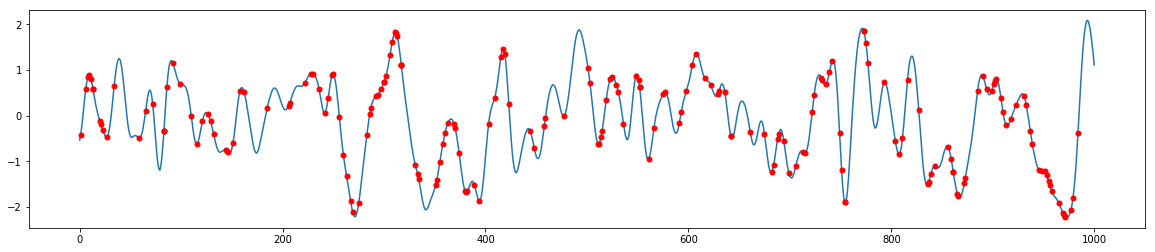

In [3]:
plot=True
if plot:
    fig = plt.figure(figsize=(20, 4))
    plt.plot(t_data, data)
    plt.plot(t_observed, data_observed, '.r', ms=10)
    plt.show()

## Build GPWiNK Model

In [4]:
sess = tf.InteractiveSession()

Set number of inducing variables for $h$ and $x$

In [5]:
nu = 10
nv = 10

Build filter kernel

In [6]:
sigma  = tf.Variable([[1.0]],  dtype=GLOBAL_DTYPE)
gamma  = tf.Variable([[1.0]],  dtype=GLOBAL_DTYPE)
alpha  = tf.Variable([[0.01]], dtype=GLOBAL_DTYPE)
filter_kernel = GaussianSquareExponentialKernel.new_kernel(sigma, gamma, alpha)

Build interdomain inducing variables

In [7]:
# inducing filter
u_locations = np.linspace(-10, 10, nu)[:, None]

sigma   = tf.Variable(np.ones((nu, 1)))
gamma   = tf.Variable(np.ones((nu, 1)))  # np.random.rand(nu, 1) + 0.5,
centre  = tf.Variable(u_locations)
j_omega = tf.Variable(np.ones((nu, 1)), dtype=GLOBAL_DTYPE)
j_phi   = tf.Variable(np.ones((nu, 1)), dtype=GLOBAL_DTYPE)

In [8]:
filter_interdomain_transform  = GaussianSquareExponentialWindow.new_window(sigma, gamma, centre, j_omega, j_phi)
filter_inducing = FilterInducingVariable(
    locations=centre,
    interdomain_transform=filter_interdomain_transform, 
    kernel=filter_kernel 
)

In [9]:
# inducing noise
v_locations = np.linspace(0, final, nv)[:, None]

sigma   = tf.Variable(tf.ones((nv, 1)))
gamma   = tf.Variable(tf.ones((nv, 1)))
centre  = tf.Variable(v_locations)
j_omega = tf.Variable(tf.ones((nv, 1)))
j_phi   = tf.Variable(tf.ones((nv, 1)))

In [10]:
noise_interdomain_transform = GaussianSquareExponentialWindow.new_window(sigma, gamma, centre, j_omega, j_phi)
noise_inducing = NoiseInducingVariable(
    locations=centre, 
    interdomain_transform=noise_interdomain_transform, 
)

Build Variational approximators

In [11]:
# variational u
mean  = tf.Variable(np.ones((nu, 1)) + 10 * np.random.rand(nu, 1)) #+ 1j * np.random.rand(n_u, 1)
alpha = tf.Variable(np.random.rand(nu, nu))
beta  = tf.Variable(np.random.rand(nu, nu))
gamma = tf.Variable(np.random.rand(nu, nu))
delta = tf.Variable(np.random.rand(nu, nu))

filter_variational = ComplexGaussian.from_params(mean, alpha, beta, gamma, delta)

In [12]:
# variational v
mean  = tf.Variable(np.ones((nv, 1)) + 10 * np.random.rand(nv, 1)) #+ 1j * np.random.rand(n_v, 1)
alpha = tf.Variable(np.random.rand(nv, nv))
beta  = tf.Variable(np.random.rand(nv, nv))
gamma = tf.Variable(np.random.rand(nv, nv))
delta = tf.Variable(np.random.rand(nv, nv))

noise_variational = ComplexGaussian.from_params(mean, alpha, beta, gamma, delta)

Create GPWiNK Object

In [13]:
t_observed = tf.convert_to_tensor(t_data[index_observed], dtype=GLOBAL_DTYPE)
data_observed = tf.convert_to_tensor(data[index_observed], dtype=GLOBAL_DTYPE)

gpwink = GPWiNK(
    t_obs=t_observed,
    y_obs=data_observed,
    filter_kernel=filter_kernel,
    filter_inducing=filter_inducing,
    noise_inducing=noise_inducing,
    filter_variational=filter_variational,
    noise_variational=noise_variational
)

In [14]:
elbo = gpwink.elbo()

In [15]:
assert False

AssertionError: 

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
elbo = sess.run(elbo)

InvalidArgumentError: Retval[0] does not have value

In [27]:
eval(m2)

TypeError: Fetch argument 0.0 has invalid type <class 'float'>, must be a string or Tensor. (Can not convert a float into a Tensor or Operation.)

---

In [18]:
def eval(expr, dtype=float):
    return pd.DataFrame(
        sess.run(
            expr
        )
    ).astype(dtype).round(2)

In [19]:
def show(expr, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    sns.heatmap(eval(expr), annot=True, cmap='gray')

In [23]:
m1 = gpwink.filter_variational.augmented_mean()
c1 = gpwink.filter_variational.augmented_covariance()
m2 = 0.
c2 = gpwink.filter_inducing.augmented_covariance()

In [ ]:
np.linalg.eigvals(
    eval(c1)
)

In [ ]:
eval(c2).iloc[0, 10]

In [ ]:
np.linalg.eigvals(
    eval(c2)
)